# Introductie tot Deep Learning met Keras en TensorFlow
## Les 9. Neurale netwerken in de praktijk

**Originele versie: Daniel Moser (UT Southwestern Medical Center)**

**Aangepast door Tijmen Muller en Joost Vanstreels (2021)**

Tijdens de eerste les van de cursus Machine Learning zijn we aan de slag gegaan met neurale netwerken en hebben we een korte introductie gegeven van convolutionele neurale netwerken (CNN's of ConvNets), één van de verschillende deep learning algoritmen.

In les 10 gaan we echt aan de slag met ConvNets, in deze les gaan we nog even goed kijken naar neurale netwerken. Sinds les 1 hebben jullie een heleboel geleerd over neurale netwerken en de code in dit notebook zou nu zo klaar als een klontje moeten zijn.

In dit notebook gaan we een aantal onderdelen van het vorige notebook nader toelichten en naar een aantal alternatieve oplossingen kijken. Het doel is om meer praktijkgerichte ervaring te krijgen met neurale netwerken, TensorFlow en Keras.

<img src="https://i.imgur.com/86wacJG.png" >

## Benodigde libraries 

We hebben een aantal libraries nodig, sommigen kennen jullie al.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import mnist     # MNIST dataset is onderdeel van Keras
from tensorflow.keras.models import Sequential  # Het type neuraal netwerk dat we gaan gebruiken

from tensorflow.keras.layers import Dense, Dropout, Activation  # Verschillende type lagen die we gaan gebruiken
from tensorflow.keras.optimizers import SGD, Adam, schedules
from tensorflow.keras import utils                              # NumPy gerelateerde tools

## Stap 1. Data exploration 

De MNIST dataset is gebundeld in Keras, we kunnen deze eenvoudig downloaden.

In [2]:
# Inladen van de dataset, deze is al gesplitst in een train- en testset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (60000, 28, 28)
y_train shape (60000,)
x_test shape (10000, 28, 28)
y_test shape (10000,)


Met matplotlib kunnen we een aantal plaatjes uit de dataset bekijken.

## Stap 2. Data preparation
### Features

We hebben vorige keer al gezien dat we de 28x28 plaatjes moeten *flatten* naar een vector met een lengte van 748. Hieronder zie je een hoe dat werkt voor een klein deel van een plaatje:

<img src='https://i.imgur.com/l049B93.png' >

In [3]:
# Let op: we schakelen hier over van een kleine letter naar een hoofdletter, zodat de originele
# Trainingsdata in `x_train` beschikbaar blijft!

X_train = x_train.reshape(60_000, 784)  # Reshape de 60.000 plaatjes van 28 x 28 matrices naar 60.000 784-lengte vectoren.
X_test = x_test.reshape(10_000, 784)

X_train = X_train.astype(np.float32)   # Verander datatype van integers naar 32-bit floats
X_test = X_test.astype(np.float32) 

X_train /= 255                         # Normaliseer de pixels door de waarde te delen door de maximale waarde (= 255)
X_test /= 255

print("Training matrix shape:", X_train.shape)
print("Testing matrix shape:", X_test.shape)

Training matrix shape: (60000, 784)
Testing matrix shape: (10000, 784)


### Target

De target variabele is een 0, 1, 2, ... of 9. Dat zijn verschillende klasses of categorieën. Kijk bijvoorbeeld maar eens naar de inhoud van een willekeurig item uit y_train:

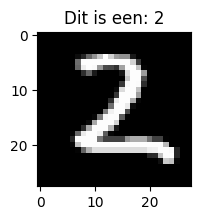

In [4]:
i = random.randrange(X_train.shape[0])
plt.figure(figsize=(2, 2))
plt.imshow(X_train[i].reshape(28, 28), cmap="gray", interpolation="none")
plt.title(f"Dit is een: {y_train[i]}")
plt.show()

In [5]:
# Met tensorflow.keras.utils wordt de one-hot encoding gedaan
nb_classes = 10 # Aantal classes

Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

print(f"Y_train: {Y_train.shape}, Y_test: {Y_test.shape}")

Y_train: (60000, 10), Y_test: (10000, 10)


## Stap 3. Modelling
We hebben de vorige keer een fully connected 3-layer network gemaakt:

<img src="https://i.imgur.com/1MR9U5c.png" />

### Model opbouwen
Dat model hebben we als volgt opgebouwd.

#### De eerste laag

In ons eerste model hadden we een input van 784 en output van 10. Nu is de input weer 784 maar de output is een eerste **hidden layer** van 512 elementen. 

In [6]:
# Gebruik model.add om de laag toe te voegen aan het model

model = Sequential()
model.add(Dense(512, input_shape=(784,))) # (784,) 

In [7]:
# Daarna voeg je de activatiefunctie 'sigmoid' weer toe
model.add(Activation("sigmoid"))

#### **NIEUW**: Dropout
Neurale netwerken kunnen soms overfitten. Overfitten kan als gevolg hebben dat een neuron z’n input krijgt van slechts één of een klein aantal neuronen van de vorige laag. Deze afhankelijkheid kan ervoor zorgen dat het netwerk goed werkt voor bepaalde trainingsvoorbeelden, maar niet op testgevallen met als gevolg overfitting.

Het doel van dropout is om deze afhankelijkheid te voorkomen. Dropout-nodes zorgen ervoor dat tijdens het trainen willekeurige neuronen uitgezet worden en later weer aangezet worden. Het gevolg is dat het een output-neuron z’n input ook van andere neuronen moet halen. Het gevolg is dat het netwerk robuuster wordt.

De dropout-lagen worden alleen gebruikt tijdens het trainen. Tijdens het evalureren van je model worden deze lagen uitgeschakelt door TensorFlow.

Meer info vind je in het boek van [Nielsen](http://neuralnetworksanddeeplearning.com/chap3.html#other_techniques_for_regularization).


**Opdracht** 

Voeg de dropout laag toe met waarde 0.2, zodat 20% van de inputs van de volgende laag wordt uitgeschakeld. Je kunt hiervoor `Dropout` gebruiken (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout).

In [8]:
model.add(Dropout(0.2))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
Total params: 401920 (1.53 MB)
Trainable params: 401920 (1.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### De tweede laag

Bij de hieropvolgende lagen hoef je geen input te definiëren: de input is de vorige laag.

In [10]:
# Voeg hier nog een laag van 512 neuronen toe met een sigmoid activation een dropout van 0.2
model.add(Dense(512))
model.add(Activation("sigmoid"))
model.add(Dropout(0.2))

####  De output laag

De laatste laag heeft 10 elementen: de 10 klasses. 

#### **NIEUW**: Softmax
Het doel van de neurale netwerken die we gezien hebben is classificeren. Op dit moment is de output een laag met outputneuronen en voor elke neuron een waarde. Elke afzonderlijke waarde zegt niet zoveel, het is belangrijk om ze onderling te vergelijken. Hiermee kun je twee zaken bepalen:

- Wat is de voorspelling? Dat is de neuron met de hoogste waarde.
- Hoe zeker is het netwerk van zijn voorspelling? Hoe hoog is deze hoogste waarde in vergelijking met de andere waarden.

Door de softmax functie te gebruiken, worden de waardes van de outputneuronen aangepast zodanig dat de som = 1 en dat de waardes eigenlijk zeggen: '*met X% zekerheid is de voorspelling y*'.

Meer info vind je in het boek van [Nielsen](http://neuralnetworksanddeeplearning.com/chap3.html#softmax).


**Opdracht**

Voeg een laag van 10 neuronen toe met een activation 'softmax', een dropout is niet nodig. Je moet hiervoor `Activation` gebruiken (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation).


In [11]:
model.add(Dense(10))
model.add(Activation("softmax"))

Nu hebben we ons model helemaal gebouwd. Het eindresultaat zou er als volgt uit moeten zien:

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
=================================================================
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
```

In [12]:
# Laten we even kijken hoe dat eruit ziet
model.summary()

# We slaan de parameters van het model op, zodat je ze eventueel later kunt gebruiken
weights_init = model.get_weights()  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5

### Compilen

Het vastleggen van de hyperparameters van een model doe je bij het *compilen*. Je herkent in de code hieronder ongetwijfeld de hyperparameters learning rate en *SGD* (die staat voor de *stochastic gradient descent* optimizer). Bij de SGD is een extra parameter toegevoegd: *momentum*. 

De standaard SGD-optimizer heeft als nadeel dat er één stapgrootte wordt genomen voor alle dimensies, ondanks dat de gradient van dimensies verschillend kan zijn. Het momentum algoritme zorgt voor een unieke stapgrootte voor elke dimensie. In onderstaande code is voor momentum een parameter toegevoegd. Meer informatie over momentum vind je in het boek van [Nielsen](http://neuralnetworksanddeeplearning.com/chap3.html#variations_on_stochastic_gradient_descent).


In [13]:
# SGD met momentum
opt = SGD(learning_rate=0.1, momentum=0.9)


#### **NIEUW**: Cross entropy loss function
De standaard Mean Squared Error loss function heeft een aantal nadelen die het convergeren moeilijker maken. Bij MNIST werkt de MSE function prima, maar bij complexere problemen niet meer. De cross entropy loss function, die ook gebruikt wordt bij decision trees, lost een aantal van die problemen op en wordt in de praktijk veel vaker gebruikt. 

Meer info vind je in het boek van [Nielsen](http://neuralnetworksanddeeplearning.com/chap3.html#the_cross-entropy_cost_function).

**Opdracht**

Compileer het model met `compile()`, waarbij je gebruik maakt van de cross entropy loss function. Zie ook https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#compile.

In [14]:
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

### Het model trainen

We hebben gezien dat je bij neurale netwerken niet altijd de optimale oplossing kunt vinden. Daarom ga je op zoek naar een oplossing die goed genoeg is. Of naar de beste oplossing in een bepaalde tijd.

Een manier om te spelen met het trainen, is de keuze voor een **batch size**. Dit bepaalt hoeveel items uit de dataset per stap bekeken worden, voordat de gewichten geüpdate worden. Grotere batch sizes zorgt voor sneller trainen, maar hebben als risico dat je in een lokaal minimum blijft hangen. Het zoeken naar de beste batch size is vaak een kwestie van trial en error.

Daarnaast is het aantal **epochs** ook belangrijk. Dit geeft aan hoe vaak je de hele trainset wilt gebruiken. Het is niet zo dat je na het bekijken van alle items uit de trainset klaar bent, je kunt de trainset nog een keer gebruiken om het model te verbeteren. En nog een keer. Enzovoorts. Zie het als het studeren voor een tentamen waarbij je een oefententamen vaker maakte om de stof te begrijpen.

In [15]:
# model.fit(X_train, Y_train,
#           batch_size=128,
#           epochs=5,
#           verbose=1) # Verbose zorgt voor een kekke animatie

Je ziet de **loss** en **accuracy**. De accuracy kennen jullie: dat is het percentage goed voorspelde cijfers. De loss functie is een functie die het verschil tussen de voorspellingen en testset berekent. Deze loss functie is erg belangrijk want deze wordt gebruikt om te trainen. De optimalisatiefunctie zoekt naar manieren om de loss functie te verlagen. Een loss van 0 is het ultieme doel!

## Stap 4. Evalueren

Leuk, die accuracy op de traindata, maar hoe goed doet ie het op de testdata?! We kijken weer naar de accuracy maar ook naar de loss (alhoewel die minder interessant is op dit moment).

In [16]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")



313/313 [==============================] - 1s 3ms/step - loss: 2.4752 - accuracy: 0.1135
Test loss: 2.4752
Test accuracy: 0.1135


Als het goed is bereik je hiermee een accuracy van ruim 95%. Dat is niet slecht, maar met een aantal simpele aanpassingen kunnen we de accuracy makkelijk verhogen.

# Deel II. Nieuwe mogelijkheden van neurale netwerken
De volgende opdrachten staan in het teken van een aantal nieuwe mogelijkheden van neurale netwerken die in de praktijk veel gebruikt worden.



## Opdracht 1. Adam optimizer in plaats van SGD

In de praktijk is gebleken dat het *standaard* SGD algoritme de nodige beperkingen heeft qua performance en resultaten, ook mét het toevoegen van *momentum*. De [RMSProp](https://www.youtube.com/watch?v=_e-LFe_igno&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc) optimizer haalde al betere resultaten maar de meest gebruikte optimizer op dit moment is de [Adam](https://www.youtube.com/watch?v=JXQT_vxqwIs&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc) optimizer die SGD, momentum en RMSProp combineert. 

De links verwijzen naar de video's van [deeplearning.ai](https://deeplearning.ai).
 

### Opdracht
Experimenteer met de Adam optimizer. Vergelijk de resultaten met het SGD en momentum. Kijk naar de snelheid van trainen en de score van het model.

**Tip**: gooi eventueel alle code hieronder in één cel zodat je snel kunt experimenteren.

In [17]:
model_adam = Sequential()
model_adam.add(Dense(512, input_shape=(784,))) # (784,)
model_adam.add(Activation("sigmoid"))
model_adam.add(Dropout(0.2))

model_adam.add(Dense(512))
model_adam.add(Activation("sigmoid"))
model_adam.add(Dropout(0.2))

model_adam.add(Dense(10))
model_adam.add(Activation("softmax"))

Vul in de cel hieronder de juiste code in om de Adam optimizer te gebruiken (zie https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) en om het model te compileren met `compile()`. Denk ook aan de loss functie en eventuele metrieken (`metrics`) die je wil gebruiken.

In [18]:
opt = Adam(learning_rate=0.001)
model_adam.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [19]:
model_adam.fit(X_train, Y_train,
               batch_size=128,
               epochs=5,
               verbose=1) 

print("________________")
loss, accuracy = model_adam.evaluate(X_test, Y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/5
261/469 [===============>..............] - ETA: 2s - loss: 0.7158 - accuracy: 0.7834

469/469 [==============================] - 6s 10ms/step - loss: 0.5394 - accuracy: 0.8375
Epoch 2/5
469/469 [==============================] - 4s 10ms/step - loss: 0.2404 - accuracy: 0.9282
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.1807 - accuracy: 0.9461
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.1400 - accuracy: 0.9573
Epoch 5/5
469/469 [==============================] - 4s 10ms/step - loss: 0.1142 - accuracy: 0.9649
________________
313/313 [==============================] - 1s 2ms/step - loss: 0.0962 - accuracy: 0.9691
Test loss: 0.0962
Test accuracy: 0.9691


## Opdracht 2. Tanh activation function

We hebben geleerd om te werken met de sigmoid activation function. Er zijn echter verschillende andere activation functions. De [tanh](https://www.youtube.com/watch?v=Xvg00QnyaIY&list=PLkDaE6sCZn6Ec-XTbcX1uRg2_u4xOEky0) functie lijkt erg op de sigmoid maar het verschil is dat de afgeleide van de tanh stijler is en dat deze naar -1 gaat. Er zijn een heleboel redenen om te kiezen voor de sigmoid of tanh maar die zijn allemaal afhankelijk van het gegeven probleem. 

 

### Opdracht
Experimenteer met de tanh activation function en vergelijk de resultaten met de sigmoid function. Kijk naar de snelheid van trainen en de score van het model. Maak daartoe in onderstaande cel hetzelfde model, maar nu met de tanh-functie (zie ook https://www.tensorflow.org/api_docs/python/tf/keras/activations/tanh).

In [20]:
model_tanh = Sequential()
model_tanh.add(Dense(512, input_shape=(784,))) # (784,)
model_tanh.add(Activation("tanh"))
model_tanh.add(Dropout(0.2))

model_tanh.add(Dense(512))
model_tanh.add(Activation("tanh"))
model_tanh.add(Dropout(0.2))

model_tanh.add(Dense(10))
model_tanh.add(Activation("softmax"))

In [21]:
opt = Adam(learning_rate=0.001)
model_tanh.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [22]:
model_tanh.fit(X_train, Y_train,
               batch_size=128,
               epochs=5,
               verbose=1) 

print("________________")
loss, accuracy = model_adam.evaluate(X_test, Y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/5


469/469 [==============================] - 6s 10ms/step - loss: 0.3125 - accuracy: 0.9056
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.1616 - accuracy: 0.9510
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.1158 - accuracy: 0.9647
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0931 - accuracy: 0.9702
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0759 - accuracy: 0.9753
________________
313/313 [==============================] - 1s 2ms/step - loss: 0.0962 - accuracy: 0.9691
Test loss: 0.0962
Test accuracy: 0.9691


## Opdracht 3. Learning rate decay
Er is geen stelregel om de juiste learning rate te kiezen, je zult moeten experimenteren met verschillende waardes. Daarnaast blijk het in de praktijk niet handig te zijn om met een constante learning rate te werken. Als je langer traint, kom je dichter bij het optimum. Op dat moment is het handiger om kleine stapjes naar dat optimum te nemen. In de praktijk is het dus handig om de learning rate te laten afnemen. Dat wordt [learning rate decay](https://www.youtube.com/watch?v=QzulmoOg2JE&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc) genoemd.

Dat kun je gepland doen met een learning rate scheduler. Na een bepaald aantal stappen of na een bepaalde tijd kun je de learning rate laten aanpassen. Een alternatief van learning rate scheduling zijn adaptive learning rate methodes: deze methodes maken de learning rate afhankelijk van de gevonden gradient. **Gebruik deze alleen wanneer je ze snapt, anders is een learning rate scheduler beter.**

### Opdracht
Bekijk de [documentatie](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/) van Keras en voeg code voor de `ExponentialDecay` scheduler toe aan het beste model dat je tot nu toe gevonden hebt. Experimenteer met de initiële learning rate, de stappen en het verval. Vergelijk de resultaten met de vorige experimenten. Kijk naar de snelheid van trainen en de score van het model. Zie ook https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay.


In [26]:
model = Sequential()
model.add(Dense(512, input_shape=(784,))) # (784,)
model.add(Activation("tanh"))
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation("tanh"))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation("softmax"))

# Exponential Decay
initial_learning_rate = 0.01
decay_steps = 10000

lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps,
    decay_rate=0.96,
    staircase=True)

opt = SGD(learning_rate=lr_schedule)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model.fit(X_train, Y_train,
            batch_size=128,
            epochs=5,
            verbose=1)

print("___________________________________________________________")
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/5


469/469 [==============================] - 4s 7ms/step - loss: 0.8511 - accuracy: 0.7770
Epoch 2/5
469/469 [==============================] - 3s 7ms/step - loss: 0.4473 - accuracy: 0.8755
Epoch 3/5
469/469 [==============================] - 3s 7ms/step - loss: 0.3856 - accuracy: 0.8894
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.3598 - accuracy: 0.8960
Epoch 5/5
469/469 [==============================] - 3s 7ms/step - loss: 0.3416 - accuracy: 0.9022
___________________________________________________________
313/313 [==============================] - 1s 3ms/step - loss: 0.3013 - accuracy: 0.9151
Test loss: 0.3013
Test accuracy: 0.9151


## Opdracht 4. L2 regularisatie
[Regularization](http://neuralnetworksanddeeplearning.com/chap3.html#other_techniques_for_regularization) is net als dropout een manier om overfitting te voorkomen. Een ander gevolg van overfitten zijn hoge gewichten waardoor er dus ook weer een sterke afhankelijkheid is tussen input en output neuronen. Het idee van regularization is om hoge gewichten te voorkomen. 

Dat doe je door de cost functie uit te breiden met een tweede deel waarin je de gekwadrateerde gewichten bij elkaar optelt. Het netwerk wordt hierdoor gestraft wanneer gewichten heel hoog worden. L2 regularization is een veelgebruikte manier om dit te doen.

### Opdracht
Bekijk de [documentatie](https://keras.io/api/layers/regularizers/) van Keras en voeg code voor de `L2` regularizer toe aan het beste model dat je tot nu toe gevonden hebt. Vergelijk de resultaten met de vorige experimenten. Kijk naar de snelheid van trainen en de score van het model. Zie ook https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2.

## Opdracht 5. Alles op een hoop!
Als het goed is, hebben de meeste experimenten voor betere resultaten gezorgd. Probeer nu om de methodes te combineren tot een überalwetend neural network! 